In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from pymongo import MongoClient

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg


In [ ]:
host = ""
client = MongoClient(host = host, port = 27017)
db = client["air-quality"]
dar = db["dar-es-salaam"]

In [ ]:
dar.count_documents({})

233262

In [ ]:
dar.find_one({})

{'timestamp': datetime.datetime(2018, 1, 1, 0, 0, 48, 41000),
 'metadata': {'lat': -6.818,
  'lon': 39.285,
  'measurement': 'temperature',
  'sensor_id': 34,
  'sensor_type': 'DHT22',
  'site': 11},
 'temperature': 30.1,
 '_id': ObjectId('6525d778f44bfedd842c72d8')}

In [ ]:
sites = dar.distinct("metadata.site")
sites

[11, 23]

In [ ]:
result = dar.aggregate(
    [
        {"$group" : {"_id" : "$metadata.site", "count" : {"$count" : {}}}}
    ]
)
readings_per_site = list(result)
readings_per_site

[{'_id': 11, 'count': 173242}, {'_id': 23, 'count': 60020}]

In [ ]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site" : 11, "metadata.measurement" : "P2"},
        projection={"P2" : 1, "timestamp" : 1, "_id" : 0},
    )

    y = pd.DataFrame(results).set_index("timestamp")

    y = y.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    y = y[y["P2"] < 100]

    y = y["P2"].resample("1H").mean().fillna(method="ffill")
    
    return y

In [ ]:
y = wrangle(dar)
print(type(y))

<class 'pandas.core.series.Series'>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(ax = ax)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.title("Dar es Salaam PM2.5 Levels");

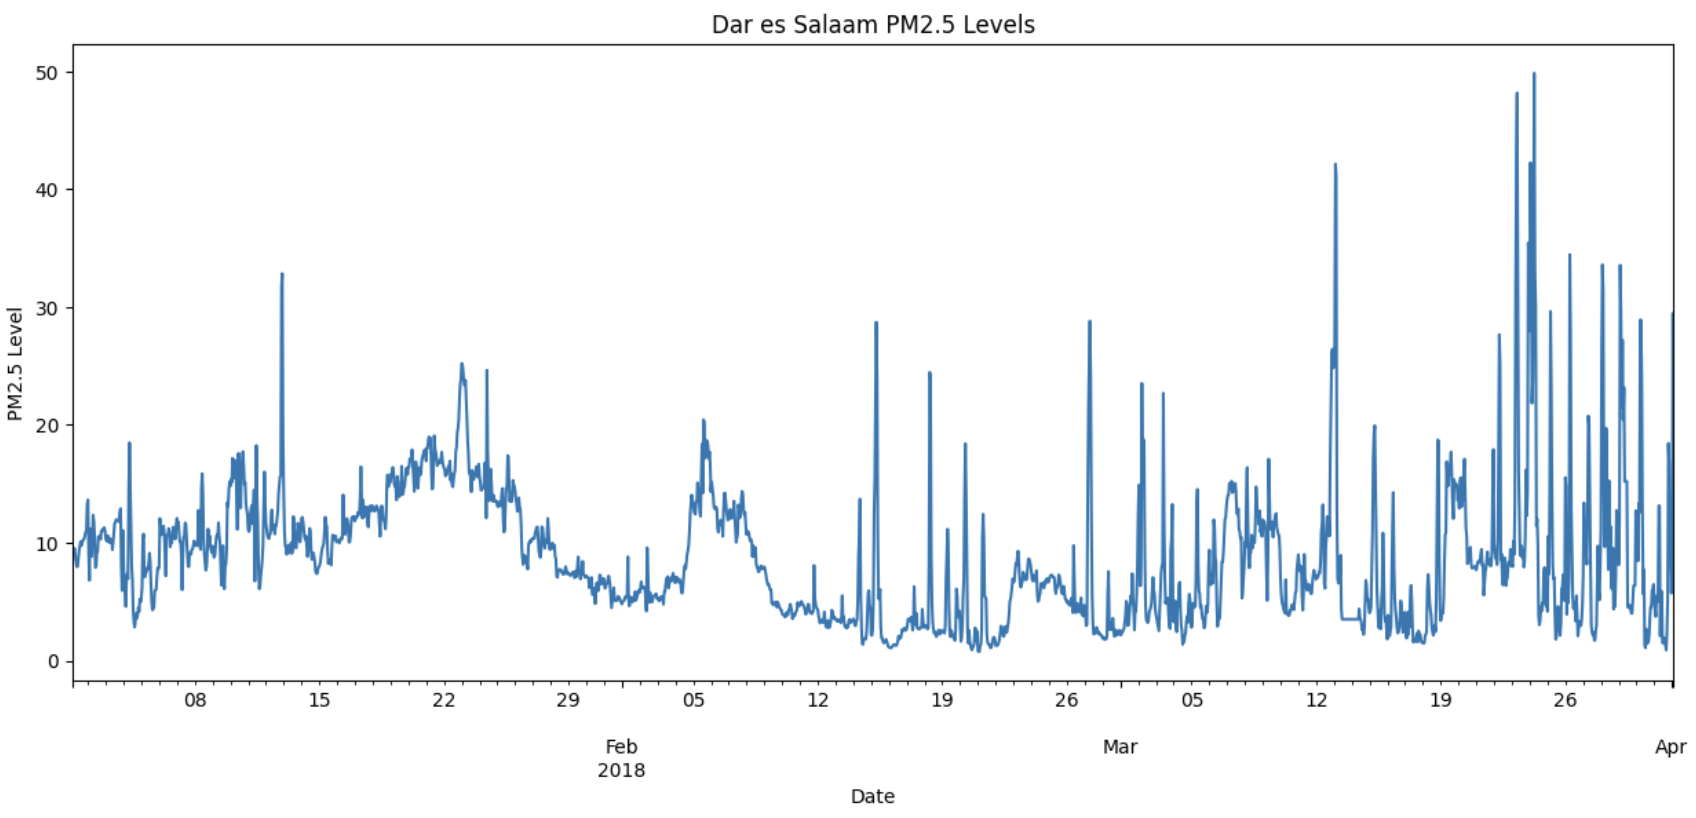

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
roll = y.rolling(168).mean()
roll.plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.title("Dar es Salaam PM2.5 Levels, 7-Day Rolling Average")

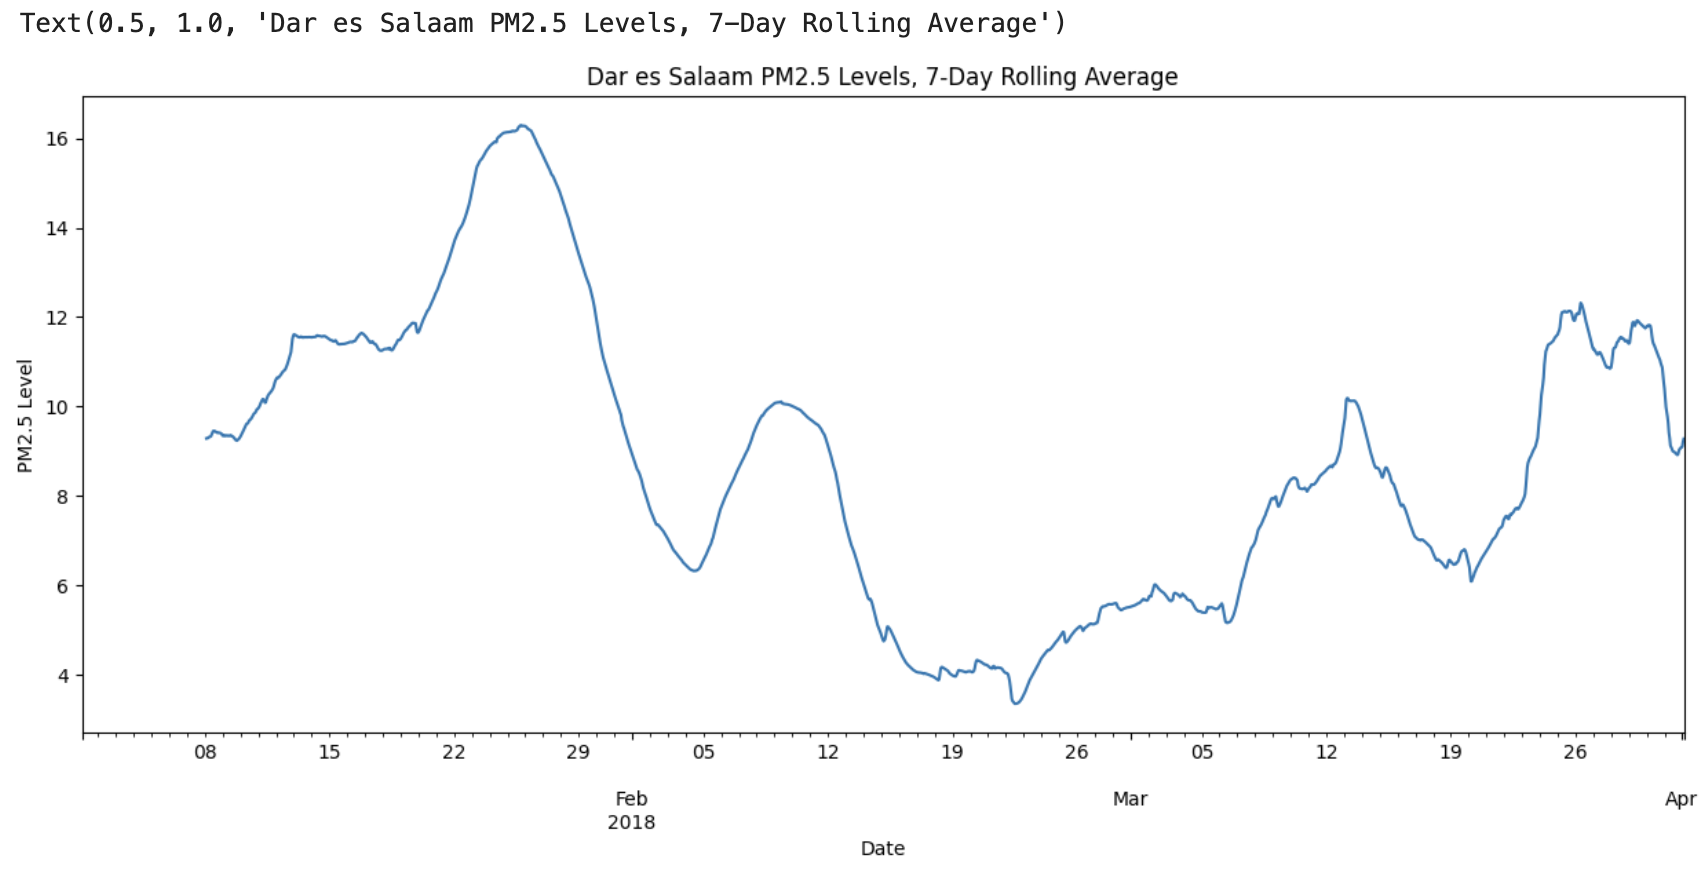

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");

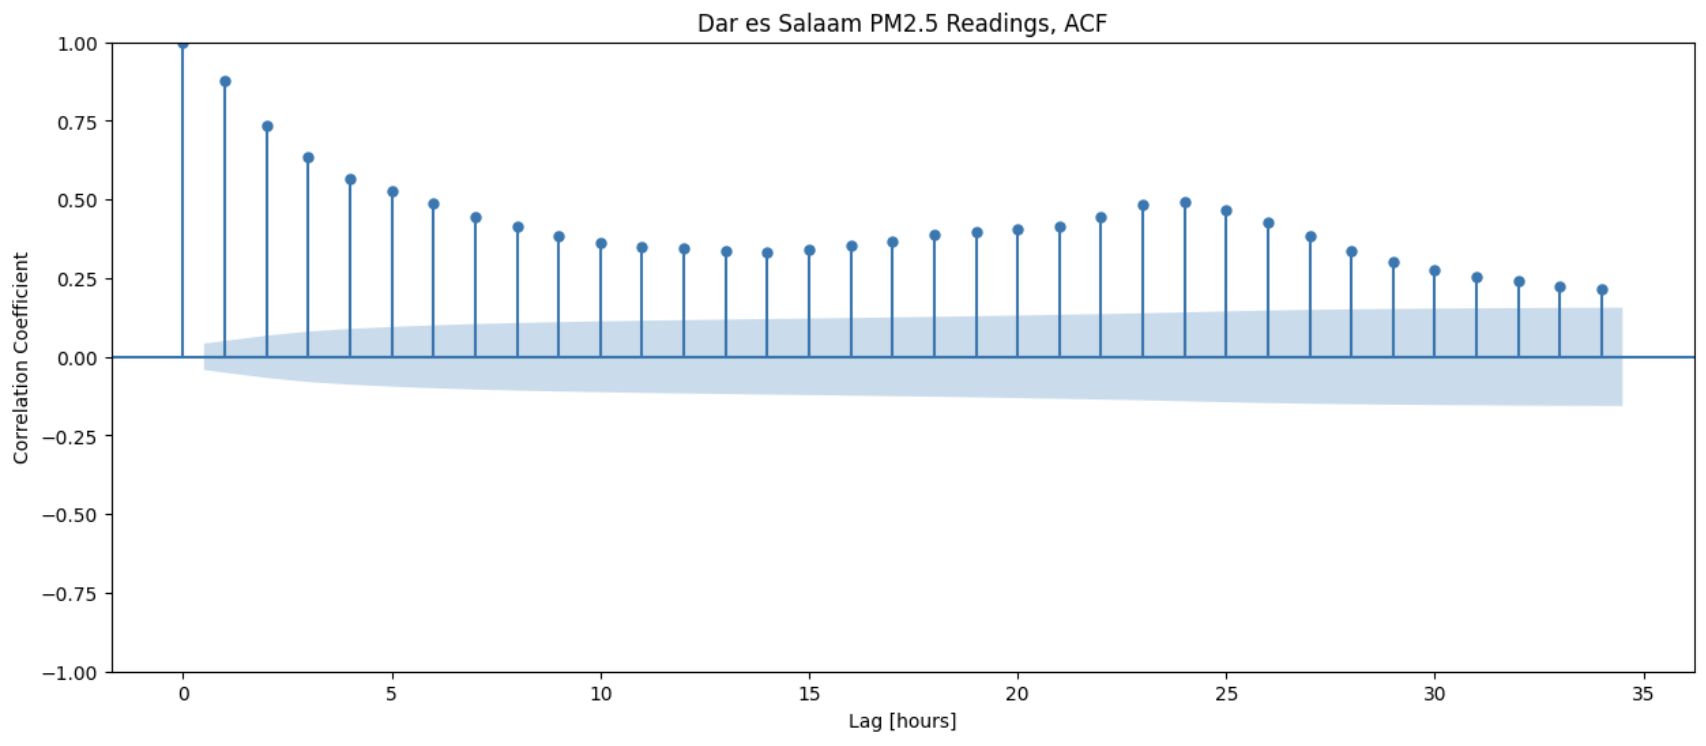

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF");

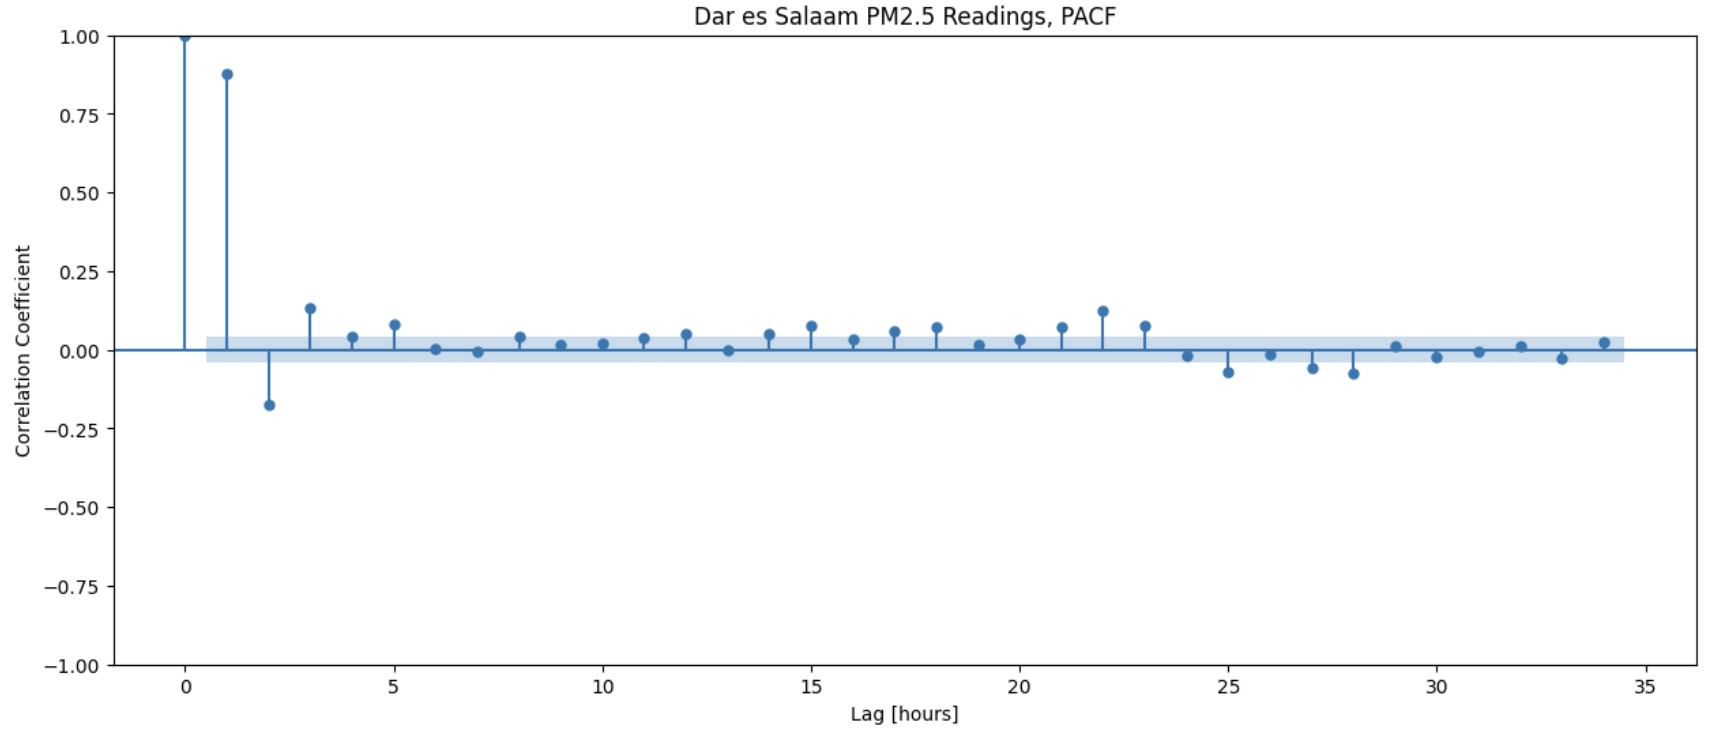

In [ ]:
cutoff_test = int(len(y)*0.9)
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.57142319061077
Baseline MAE: 4.053101181299159

In [ ]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags=p).fit()

    y_pred = model.predict().dropna()

    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    maes.append(mae)

mae_series = pd.Series(maes, name="mae", index=p_params)

mae_series

1     1.059376
2     1.045182
3     1.032489
4     1.032147
5     1.031022
6     1.026948
7     1.023510
8     1.022944
9     1.022321
10    1.022058
11    1.018001
12    1.018568
13    1.019006
14    1.018080
15    1.018818
16    1.021036
17    1.021398
18    1.021820
19    1.020472
20    1.019727
21    1.017981
22    1.017824
23    1.014569
24    1.013427
25    1.010657
26    1.010285
27    1.010619
28    1.010287
29    1.012046
30    1.016535
Name: mae, dtype: float64

In [ ]:
best_p = 26
best_model = AutoReg(y_train, lags=26).fit()

In [ ]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid

timestamp
2018-01-02 05:00:00+03:00   -0.412913
2018-01-02 06:00:00+03:00    1.484934
2018-01-02 07:00:00+03:00    1.672359
2018-01-02 08:00:00+03:00   -0.368030
2018-01-02 09:00:00+03:00   -0.536868
                               ...   
2018-03-22 22:00:00+03:00   -0.157974
2018-03-22 23:00:00+03:00   -1.114870
2018-03-23 00:00:00+03:00    0.495103
2018-03-23 01:00:00+03:00    0.030638
2018-03-23 02:00:00+03:00    2.401650
Freq: H, Name: residuals, Length: 1918, dtype: float64

In [ ]:
fig, ax = plt.subplots()
y_train_resid.hist(ax=ax)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");

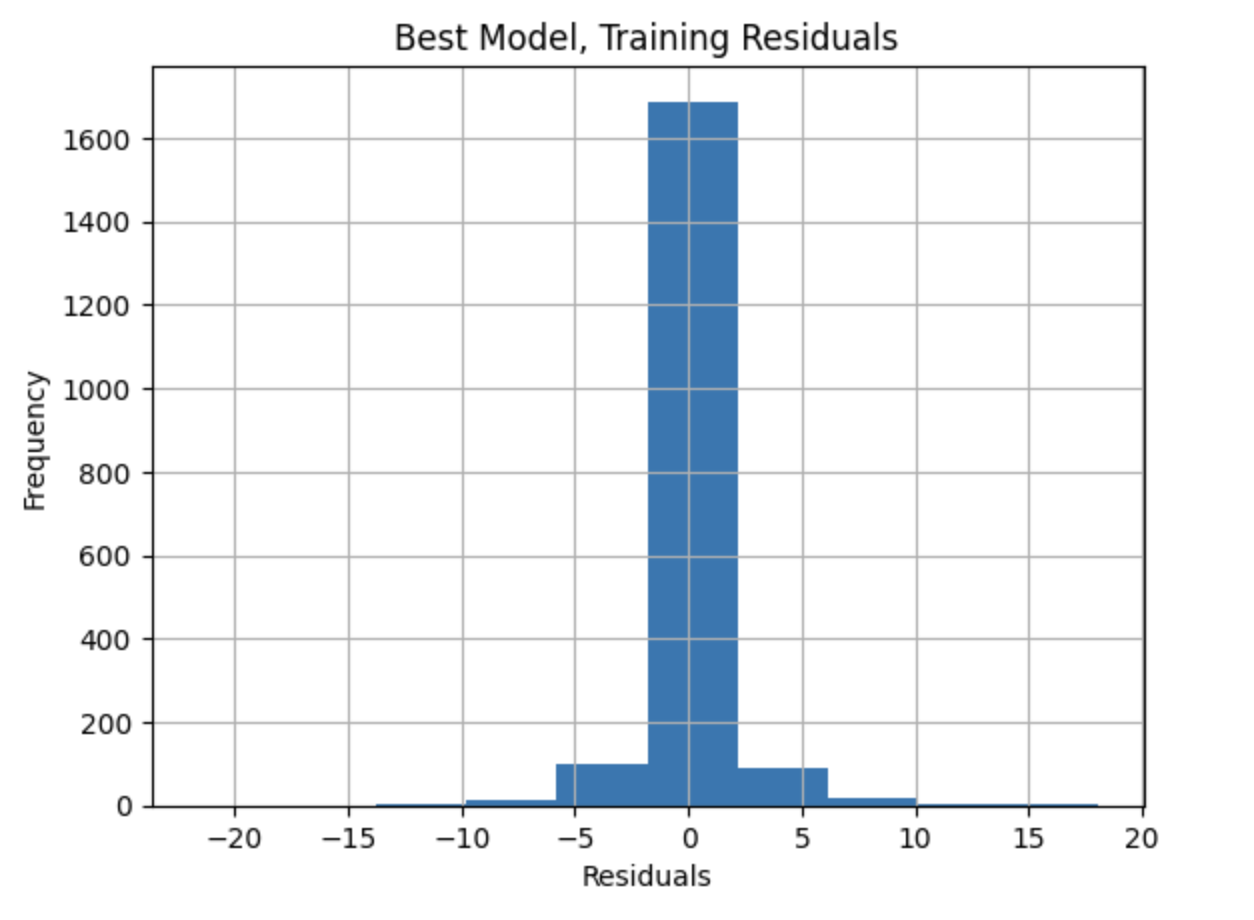

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title('Dar es Salaam, Training Residuals ACF')

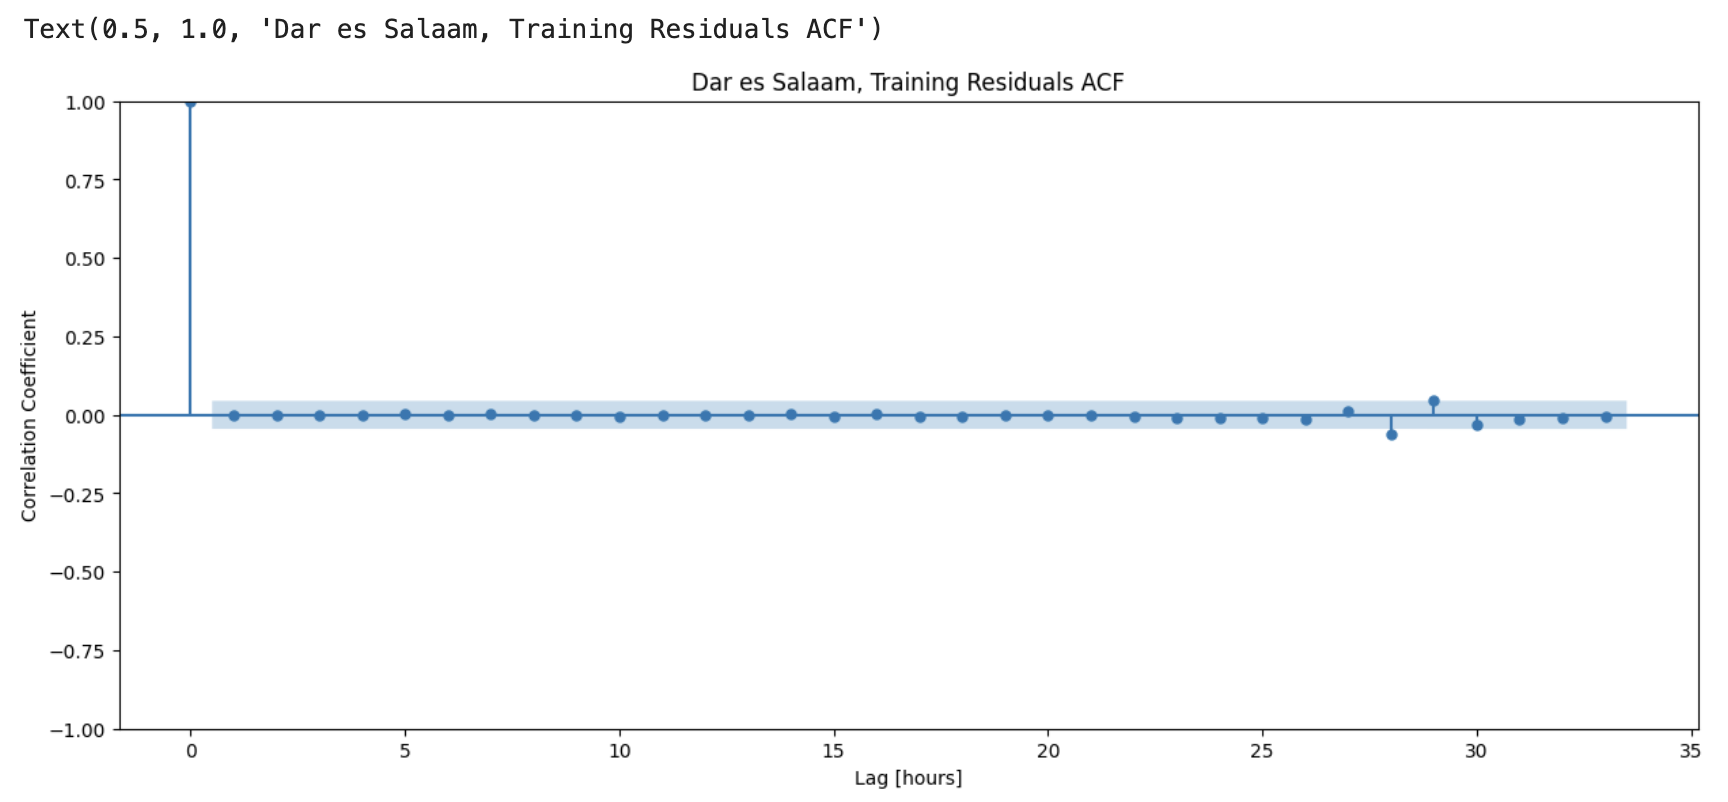

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags = 26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-03-23 03:00:00+03:00    10.414744
2018-03-23 04:00:00+03:00     8.269589
2018-03-23 05:00:00+03:00    15.178677
2018-03-23 06:00:00+03:00    33.475398
2018-03-23 07:00:00+03:00    39.571363
Freq: H, Name: prediction, dtype: float64

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.97

In [ ]:
df_pred_test = pd.DataFrame(
    {'y_test' : y_test, "y_pred_wfv" : y_pred_wfv}
)
fig = px.line(df_pred_test)
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)

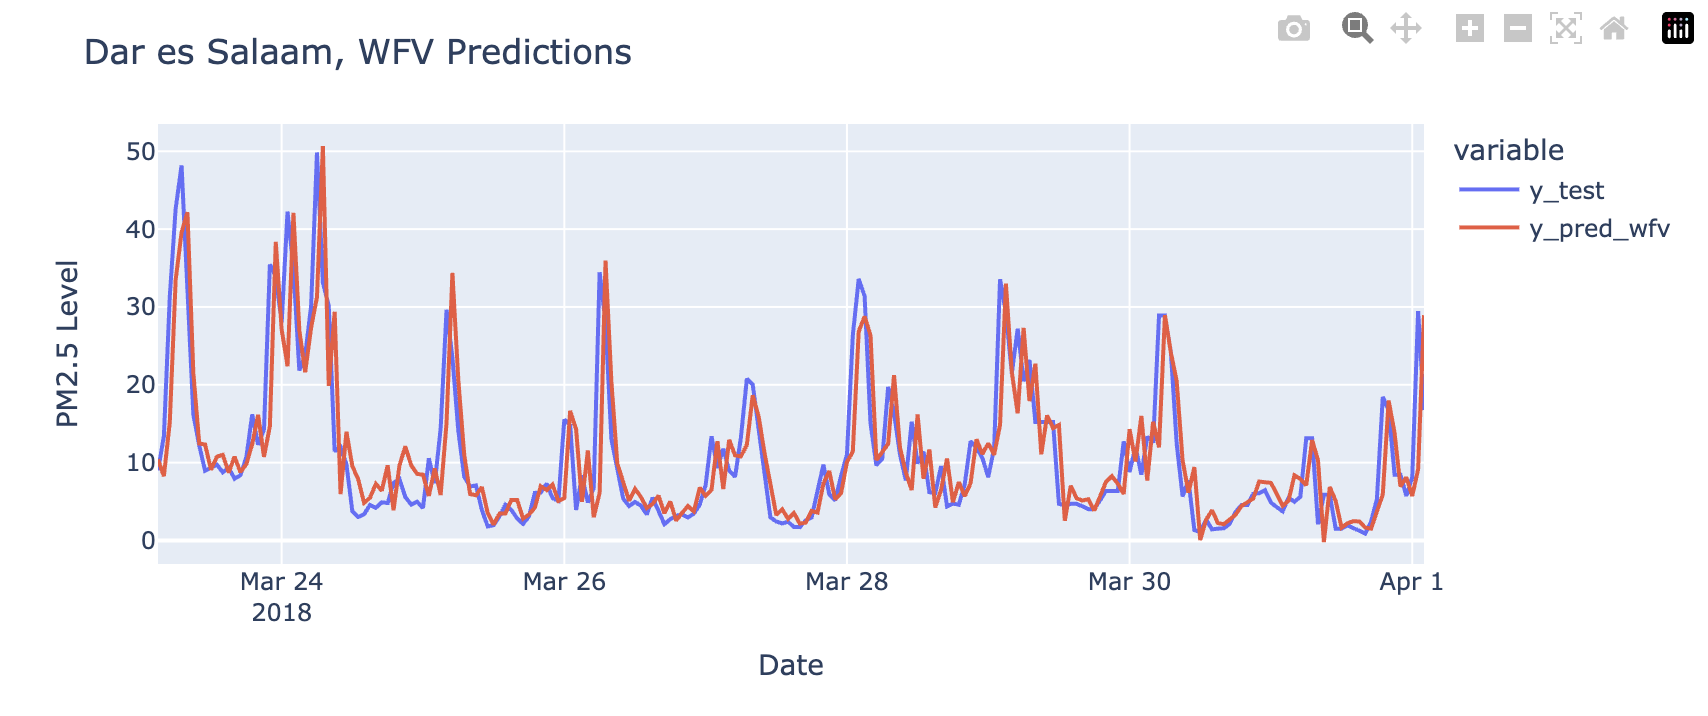